<a href="https://colab.research.google.com/github/nicolascarva/HURDAT/blob/Decades/Hurdat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#test comment
import pandas as pd
import numpy as np
from google.colab import files
url='https://raw.githubusercontent.com/nicolascarva/HURDAT/main/hurdat2-1851-2019-052520.csv'



PDF to data information: https://www.aoml.noaa.gov/hrd/hurdat/hurdat2-format.pdf

#Data Wrangling:

###Data consists of one row with information identifying hurricane (Primary Row) and subsequent rows with information known about the hurricane at specific date &  time (Data Rows) - up until the next Primary Row

###We'll add a column with the hurricane id and name concatenated, this will be our unique identifier; we'll fill all subsequent rows with the same identifier (id-name), up until the next Primary Row. We'll also add a column to tag data rows to be dropped later. Invalid values for windspeed (-99) and pressure (-999) will be replaced by NaN

In [14]:
df=pd.read_csv(url, names=['id', 'time', 'record_identifier','status','latitude','longitude','max_sust_wind', 'min_press',])
#Add Unique identifier (id-name) column
df['id-name']=(df['id']*df['max_sust_wind'].isnull()+df['max_sust_wind'].isnull()*df['time'])
df.loc[(df['id-name']==''),'id-name']=np.NaN #Set Data Rows in id-name columns as NaN to be filled in subsequent step


u_hur_=df['id-name'].value_counts().sum() # of unique hurricanes in dataset.
print(u_hur_)


1893


In [15]:

df.loc[(df['min_press']==-999, 'min_press')]=np.NaN #Set unknown minimum pressure as NaN
df.loc[(df['max_sust_wind']==-99.0, 'max_sust_wind')]=np.NaN #Set unknown maximum sustained wind as NaN
print('Datapoints with negative number for wind: ',df.loc[df['max_sust_wind']<0].value_counts().sum())
print('Datapoints with negative number for pressure: ',df.loc[df['min_press']<0].value_counts().sum())

Datapoints with negative number for wind:  0
Datapoints with negative number for pressure:  0


In [18]:
df['drop_']=df['id-name'] # Add column to tag rows to be dropped later
df['id-name'].fillna(method='ffill',inplace=True) #Fill id-name column
pd.set_option('display.max_rows', 200) #Allow the display of more rows when needed
print('Number of unique hurricanes: ', len(df['id-name'].value_counts()))

Number of unique hurricanes:  1893


###Tagging hurricanes which made landfall at some point during their recorded history (1 for landfall, 0 for no landfall), and recording the windspeed at landfall.

In [21]:
#Adding lf column if storm makes landfall (1 for landfall, 0 for no landfall)
for i in range (len(df)):
  df['record_identifier'][i]=df['record_identifier'][i].strip()

df.loc[df['record_identifier']=='L',['lf']]=1 #Tag hurricanes that made landfall with a 1 (to be grouped later)
df.loc[df['record_identifier']!='L',['lf']]=0
df['wind_speed_lf']=df['lf']*df['max_sust_wind'] #Record windspeed at landfal
df['wind_speed_lf']=df['wind_speed_lf'].replace(0, np.nan)  #Replace 0 with NaN
print('')
print('Number of hurricanes that made landfall: ', len(df[df['lf']==1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Number of hurricanes that made landfall:  1016


##Now we'll create a dataframe with each unique hurricane and information about decade it occured, mean, median and maximum wind speed recorded, minimum pressure recorded, whether they made landfall and the windspeed at landfall.

First we'll create Dataframes with the information about each hurricane

In [25]:
#Create dataframe with max wind speed, mean wind speed, minimum pressure, mean pressure, landfall status,  of each hurricane
max_speed=df.groupby(['id-name'], sort=None)['max_sust_wind'].max()
max_speed=pd.DataFrame(max_speed)
max_speed.reset_index(inplace=True)
max_speed.rename(columns={"max_sust_wind": "max_wind"}, inplace=True)
# print('Max Speed reached: ', max_speed)
max_speed.loc[max_speed['max_wind']<0]

mean_speed=df.groupby(['id-name'], sort=None)['max_sust_wind'].mean()
mean_speed=round(pd.DataFrame(mean_speed),1)
mean_speed.reset_index(inplace=True)
mean_speed.rename(columns={"max_sust_wind": "mean_wind"}, inplace=True)
# print('Mean of Maximum Speed: ', mean_speed)

median_speed=df.groupby(['id-name'], sort=None)['max_sust_wind'].median()
median_speed=round(pd.DataFrame(median_speed),1)
median_speed.reset_index(inplace=True)
median_speed.rename(columns={"max_sust_wind": "median_wind"}, inplace=True)


min_pressure=df.groupby(['id-name'], sort=None)['min_press'].min()
min_pressure=pd.DataFrame(min_pressure)
min_pressure.reset_index(inplace=True)
# print('Minimum Pressure reached: ', min_pressure)

mean_pressure=df.groupby(['id-name'], sort=None)['min_press'].mean()
mean_pressure=round(pd.DataFrame(mean_pressure),1)
mean_pressure.reset_index(inplace=True)
mean_pressure.rename(columns={"min_press": "mean_of_min_press"}, inplace=True)
# print('Mean of Minimum Pressure: ', mean_pressure)

lf=df.groupby(['id-name'], sort=None)['lf'].max()
lf=pd.DataFrame(lf)
lf.reset_index(inplace=True)
# print('Landfall status: ', lf)
# lf.head()


ws_lf=df.groupby(['id-name'], sort=None)['wind_speed_lf'].mean()
ws_lf=pd.DataFrame(ws_lf)
ws_lf.reset_index(inplace=True)
print('Number of hurricanes that made landfall: ', len(df[df['lf']==1]))

Number of hurricanes that made landfall:  1016


Now we'll create the new dataframe and call it df_hur

In [ ]:
#drop rows to keep unique hurricanes
df_hur=df.dropna(subset=['drop_'])
df_hur.drop(columns=['status','latitude','longitude', 'drop_', 'record_identifier','max_sust_wind',	'min_press', 'lf', 'wind_speed_lf'], inplace=True)

df_hur.rename(columns={"time": "Name"}, inplace=True)


#Add year column
df_hur['year']=df_hur['id'].str[-4:]
df_hur.reset_index() 
df_hur['year'] = pd.DatetimeIndex(pd.to_datetime(df_hur['year'])).year #Change year format to integer

#Add decade column 185 = 1850's 199=1990's, etc.
df_hur['dec']=df_hur['year'].div(10).astype(int)

#Add max speed column
df_hur=pd.merge(df_hur, max_speed, on=['id-name'])

# Add mean wind column
df_hur=pd.merge(df_hur, mean_speed, on=['id-name'])

# Add median wind column
df_hur=pd.merge(df_hur, median_speed, on=['id-name'])

#Add min press column
df_hur=pd.merge(df_hur, min_pressure, on=['id-name'])

#Add mean press column
df_hur=pd.merge(df_hur, mean_pressure, on=['id-name'])

#Add lf column
df_hur=pd.merge(df_hur, lf, on=['id-name'])

#Add ws_lf column
df_hur=pd.merge(df_hur, ws_lf, on=['id-name'])


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__

,id,Name,id-name,year,dec,max_wind,mean_wind,median_wind,min_press,mean_of_min_press,lf,wind_speed_lf


#Group data by Years:

In [ ]:
#Group data by years 
max_wind_year=df_hur.groupby(['year'], sort=None)['max_wind'].max()

median_of_max_wind_year=df_hur.groupby(['year'], sort=None)['max_wind'].median()

min_press_year=df_hur.groupby(['year'], sort=None)['min_press'].min()

num_hur_year=df_hur['year'].value_counts()

lf_year=df_hur.groupby(['year'],sort=None)['lf'].sum()

ws_lf_year=df_hur.groupby(['year'],sort=None)['wind_speed_lf'].mean()  #Calculate mean wind speed recorded of hurricanes at time of landfall


# unique_years=df_hur['year'].unique()
# unique_years
df_year=pd.DataFrame({'year': df_hur['year'].unique(), 'max_wind': max_wind_year, 'median_of_max_wind_year': median_of_max_wind_year, 'min_press': min_press_year, 'No_of_Hurricanes': num_hur_year, 'No_of_lf_Hurricanes': lf_year, 'mean_ws_at_lf': round(ws_lf_year,1)})

df_year['lf_perc']=round(df_year['No_of_lf_Hurricanes']/df_year['No_of_Hurricanes']*100,2)
df_year.head(10)

,year,max_wind,median_of_max_wind_year,min_press,No_of_Hurricanes,No_of_lf_Hurricanes,mean_ws_at_lf,lf_perc
1851,1851,100.0,70.0,NaN,6,3.0,76.7,50.00
1852,1852,100.0,80.0,961.0,5,3.0,86.7,60.00
1853,1853,130.0,60.0,924.0,8,0.0,NaN,0.00
1854,1854,110.0,70.0,938.0,5,3.0,86.7,60.00
1855,1855,110.0,90.0,997.0,5,1.0,110.0,20.00
1856,1856,130.0,70.0,934.0,6,3.0,90.0,50.00
1857,1857,90.0,80.0,961.0,4,2.0,70.0,50.00
1858,1858,90.0,80.0,979.0,6,1.0,70.0,16.67
1859,1859,110.0,85.0,938.0,8,3.0,70.0,37.50
1860,1860,110.0,90.0,NaN,7,3.0,96.7,42.86


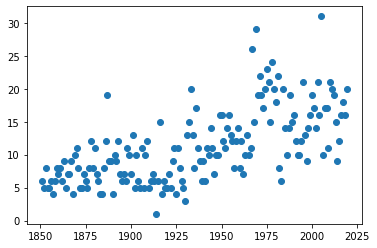

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df_year['year'], df_year['No_of_Hurricanes'], )

In [ ]:
df.loc[df['max_sust_wind']<30].head(100)

,id,time,record_identifier,status,latitude,longitude,max_sust_wind,min_press,id-name,drop_,lf,wind_speed_lf
5305,18860821,1800,,TD,33.5N,101.3W,25.0,NaN,AL051886 UNNAMED,NaN,0.0,NaN
5938,18871019,1800,,TD,31.7N,51.3W,25.0,NaN,AL151887 UNNAMED,NaN,0.0,NaN
6056,18871212,1800,,TD,10.5N,83.6W,25.0,NaN,AL191887 UNNAMED,NaN,0.0,NaN
6069,18880618,1800,,TD,31.3N,96.6W,25.0,NaN,AL011888 UNNAMED,NaN,0.0,NaN
6775,18910708,0000,,TD,34.6N,89.7W,25.0,NaN,AL011891 UNNAMED,NaN,0.0,NaN
6776,18910708,0600,,TD,35.0N,88.1W,25.0,NaN,AL011891 UNNAMED,NaN,0.0,NaN
6828,18910829,1800,,EX,43.3N,64.0W,25.0,NaN,AL021891 UNNAMED,NaN,0.0,NaN
7312,18920923,1800,,TD,38.2N,41.9W,25.0,NaN,AL051892 UNNAMED,NaN,0.0,NaN
7952,18940809,0600,,TD,31.3N,89.9W,25.0,NaN,AL021894 UNNAMED,NaN,0.0,NaN
7953,18940809,1200,,TD,31.5N,90.5W,25.0,NaN,AL021894 UNNAMED,NaN,0.0,NaN


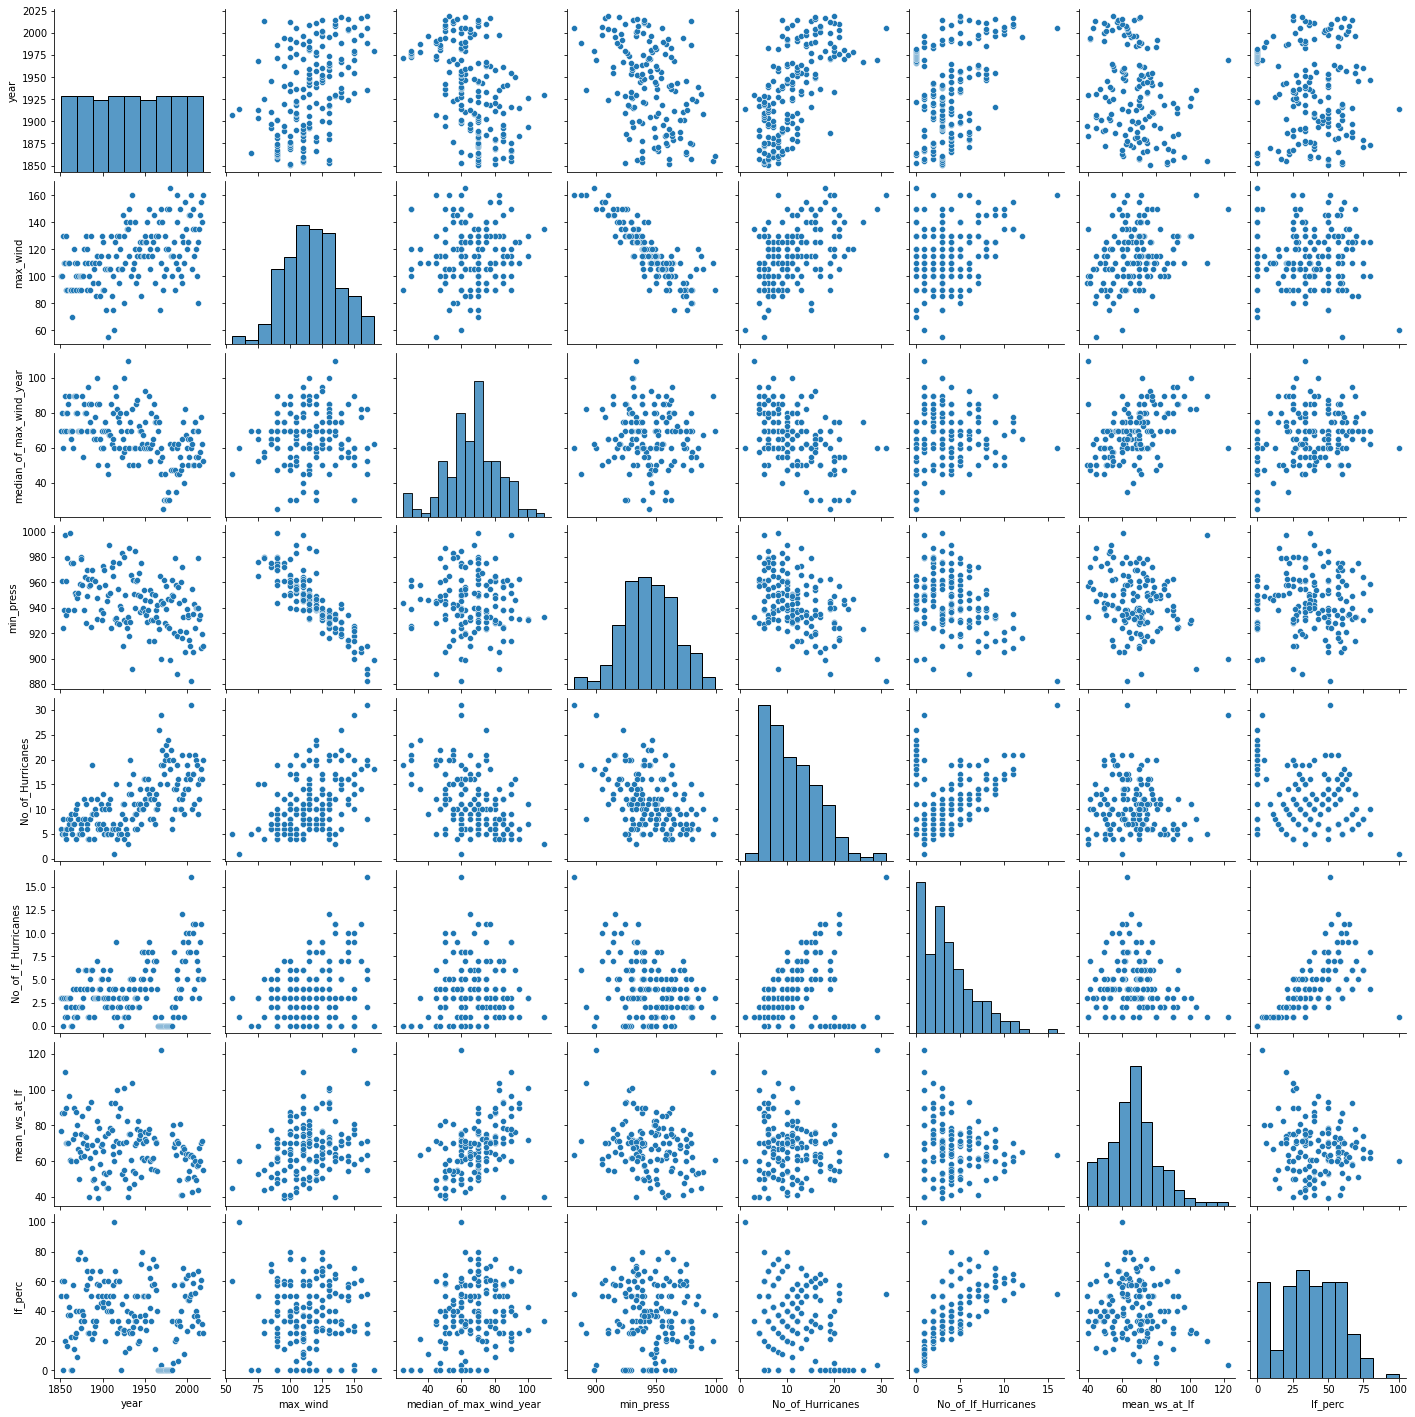

In [ ]:
import seaborn as sns
sns.pairplot(df_year)

In [ ]:
df_year.loc[df_year['median_of_max_wind_year']<0]

,year,max_wind,median_of_max_wind_year,min_press,No_of_Hurricanes,No_of_lf_Hurricanes,mean_ws_at_lf,lf_perc
1967,1967,140.0,-99.0,923.0,26,0.0,NaN,0.0


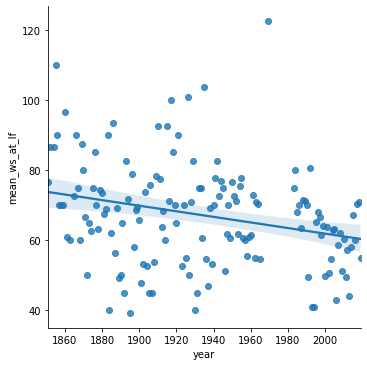

In [ ]:
sns.lmplot(x='year', y='mean_ws_at_lf',data=df_year, ci=95)

In [ ]:
from statsmodels.formula.api import ols
model=ols('mean_ws_at_lf ~ year + max_wind', data=df_year).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          mean_ws_at_lf   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     30.82
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           6.84e-12
Time:                        00:53:58   Log-Likelihood:                -585.31
No. Observations:                 149   AIC:                             1177.
Df Residuals:                     146   BIC:                             1186.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    325.0948     42.861      7.585      0.0

In [ ]:
from statsmodels.formula.api import ols
model=ols('max_wind ~ year', data=df_year).fit()
print(model.summary())

In [ ]:
from statsmodels.formula.api import ols
model=ols('No_of_Hurricanes ~ year', data=df_year).fit()
print(model.summary())

In [ ]:
from statsmodels.formula.api import ols
model=ols('max_wind ~ year', data=df_year).fit()
print(model.summary())

By Decades:

In [ ]:
#Group data by decades 
max_wind_dec=df_hur.groupby(['dec'], sort=None)['max_wind'].max()
max_wind_dec

min_press_dec=df_hur.groupby(['dec'], sort=None)['min_press'].min()

num_hur_dec=df_hur['dec'].value_counts()

lf_dec=df_hur.groupby(['dec'],sort=None)['lf'].sum()

ws_lf_dec=df_hur.groupby(['dec'],sort=None)['wind_speed_lf'].mean()  #Calculate mean wind speed recorded of hurricanes at time of landfall


# unique_decs=df_hur['dec'].unique()
# unique_decs
df_dec=pd.DataFrame({'dec': df_hur['dec'].unique(), 'max_wind': max_wind_dec, 'min_press': min_press_dec, 'No_of_Hurricanes': num_hur_dec, 'No_of_lf_Hurricanes': lf_dec, 'mean_ws_at_lf': round(ws_lf_dec,1)})

df_dec['lf_perc']=round(df_dec['No_of_lf_Hurricanes']/df_dec['No_of_Hurricanes']*100,2)
df_dec.head(30)

,dec,max_wind,min_press,No_of_Hurricanes,No_of_lf_Hurricanes,mean_ws_at_lf,lf_perc
185,185,130.0,924.0,53,19.0,81.6,35.85
186,186,120.0,938.0,72,20.0,76.6,27.78
187,187,120.0,938.0,75,32.0,68.5,42.67
188,188,130.0,925.0,89,40.0,69.3,44.94
189,189,130.0,930.0,82,38.0,66.5,46.34
190,190,125.0,936.0,84,37.0,60.5,44.05
191,191,130.0,924.0,61,31.0,75.8,50.82
192,192,145.0,910.0,71,22.0,71.8,30.99
193,193,160.0,892.0,115,34.0,63.0,29.57
194,194,125.0,937.0,104,44.0,66.9,42.31


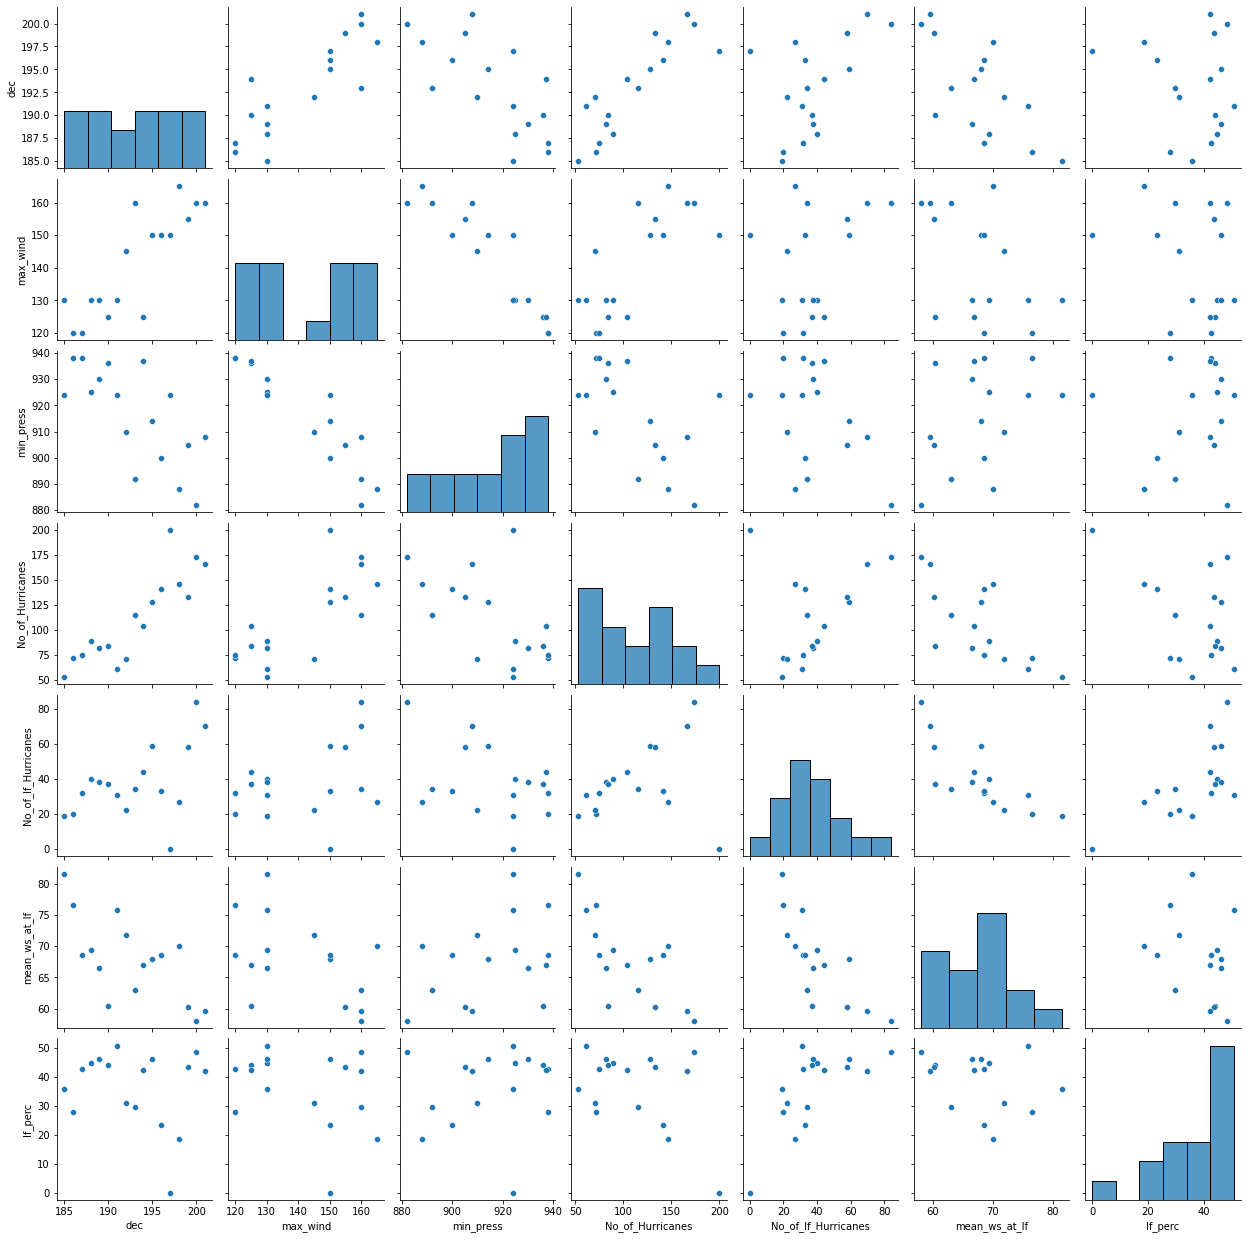

In [ ]:
import seaborn as sns
sns.pairplot(df_dec)

In [ ]:
model=ols('mean_ws_at_lf ~ dec', df_dec).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          mean_ws_at_lf   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.4847
Date:                Mon, 01 Feb 2021   Prob (F-statistic):              0.496
Time:                        01:31:50   Log-Likelihood:                -72.771
No. Observations:                  18   AIC:                             149.5
Df Residuals:                      16   BIC:                             151.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    160.4587    128.622      1.248      0.2

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


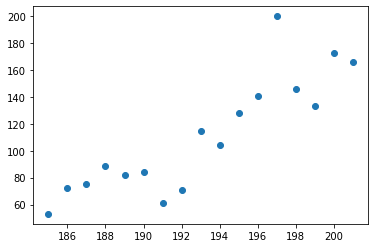

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df_dec['dec'], df_dec['No_of_Hurricanes'])